In [1]:
!pip install tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
print("--- Starting LSTM (1-Step) Model Training ---")

# --- Configuration ---
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'
MODEL_FILE = 'lstm_model_1step.keras' # Renamed
X_SCALER_FILE = 'lstm_x_scaler_1step.joblib' # Renamed
Y_SCALER_FILE = 'lstm_y_scaler_1step.joblib' # Renamed
CHART_FILE = 'lstm_prediction_vs_actual_1step.png' # Renamed

# --- Model Hyperparameters ---
N_LOOKBACK = 72 # Past 72 hours
#
# *** THE ONLY CHANGE IS HERE ***
#
N_FORECAST = 1  # Predict only the next 1 hour (was 24)
#
# ********************************
#

# --- Data Configuration ---
TARGET_COLUMN = 'Phase3_power'
FEATURES = [
    'Phase2_current', 
    'Phase2_voltage', 
    'Phase3_frequency', 
    'Phase3_pf', 
    'Phase3_power', 
    'Phase3_voltage'
]
SPLIT_DATE = '2021-05-20'


--- Starting LSTM (1-Step) Model Training ---


In [4]:
print(f"Loading cleaned data from {CLEANED_DATA_FILE}...")
df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)
# Drop the bad data period we found earlier
df.dropna(how='all', inplace=True) 

# Separate features (X) and target (y)
X_data = df[FEATURES]
y_data = df[[TARGET_COLUMN]] # Keep as 2D DataFrame

print(f"Data loaded. X shape: {X_data.shape}, y shape: {y_data.shape}")

Loading cleaned data from data/cleaned_bangalore_data.csv...
Data loaded. X shape: (3188, 6), y shape: (3188, 1)


In [5]:
# --- Step 2: Scale the Data ---
print("Scaling data (fitting on training data only)...")

# Find the split index
split_index = len(df.loc[df.index < SPLIT_DATE])

# Split data *before* scaling
X_train_df = X_data.iloc[:split_index]
X_test_df = X_data.iloc[split_index:]

y_train_df = y_data.iloc[:split_index]
y_test_df = y_data.iloc[split_index:]

# Create and fit scalers *only* on the training data
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = X_scaler.fit_transform(X_train_df)
X_test_scaled = X_scaler.transform(X_test_df)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train_df)
y_test_scaled = y_scaler.transform(y_test_df)

# Save the scalers for later use (in the API)
joblib.dump(X_scaler, X_SCALER_FILE)
joblib.dump(y_scaler, Y_SCALER_FILE)
print(f"Scalers created and saved to {X_SCALER_FILE} and {Y_SCALER_FILE}")

# Combine scaled data for sequencing
X_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y_scaled = np.concatenate((y_train_scaled, y_test_scaled), axis=0)

Scaling data (fitting on training data only)...
Scalers created and saved to lstm_x_scaler_1step.joblib and lstm_y_scaler_1step.joblib


In [6]:
# --- Step 3: Create "Windowed" Sequences ---
def create_sequences(x_data, y_data, n_lookback, n_forecast):
    """
    Creates sequences for LSTM.
    X: (samples, n_lookback, n_features)
    y: (samples, n_forecast)
    """
    X, y = [], []
    for i in range(len(x_data) - n_lookback - n_forecast + 1):
        X.append(x_data[i : (i + n_lookback)])
        # Get the next N_FORECAST values from the target column
        y.append(y_data[i + n_lookback : i + n_lookback + n_forecast].flatten())
    return np.array(X), np.array(y)

print("Creating sequences...")
X_seq, y_seq = create_sequences(X_scaled, y_scaled, N_LOOKBACK, N_FORECAST)

print(f"Sequences created. X shape: {X_seq.shape}, y shape: {y_seq.shape}")

Creating sequences...
Sequences created. X shape: (3116, 72, 6), y shape: (3116, 1)


In [7]:
# --- Step 4: Train/Test Split (on Sequences) ---
# We split the sequences based on the original split_index
# Adjust the split_index to account for the lookback
split_point = split_index - N_LOOKBACK

X_train, X_test = X_seq[:split_point], X_seq[split_point:]
y_train, y_test = y_seq[:split_point], y_seq[split_point:]

print(f"Train sequences: X={X_train.shape}, y={y_train.shape}")
print(f"Test sequences:  X={X_test.shape}, y={y_test.shape}")

if X_train.shape[0] == 0 or X_test.shape[0] == 0:
    print("ERROR: Train or test set is empty after sequencing. Adjust split date or data.")
    exit()

Train sequences: X=(969, 72, 6), y=(969, 1)
Test sequences:  X=(2147, 72, 6), y=(2147, 1)


In [8]:
# --- Step 5: Build LSTM Model ---
print("Building LSTM model...")
model = Sequential()
# Input Layer: 50 units, return sequences for the next LSTM layer
model.add(LSTM(
    50, 
    return_sequences=True, 
    input_shape=(N_LOOKBACK, len(FEATURES))
))
model.add(Dropout(0.2))
# Hidden Layer: 50 units
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
# Output Layer: N_FORECAST (24) neurons to predict the next 24 hours
model.add(Dense(N_FORECAST))

model.compile(optimizer='adam', loss='mse')
model.summary()

Building LSTM model...


c:\Users\dhanu\OneDrive\Dokumen\projects\City_Electricity_Demand_Forecasting\backend_ml\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# --- Step 6: Train Model ---
print("Training model...")
# Stop training if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50, # Set a max of 50, but early stopping will likely finish sooner
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("Model training complete.")

Training model...
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0386 - val_loss: 0.0396
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0320 - val_loss: 0.0430
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0290 - val_loss: 0.0332
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0255 - val_loss: 0.0341
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0227 - val_loss: 0.0370
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0221 - val_loss: 0.0297
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0203 - val_loss: 0.0253
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0209 - val_loss: 0.0335
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0212 - val_loss: 0.0375
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0201 - val_loss: 0.0249
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0200 - val_loss: 0.0287
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75m

In [10]:

# --- Step 7: Save Model ---
print(f"Saving model to {MODEL_FILE}...")
model.save(MODEL_FILE)
print("Model saved successfully.")

Saving model to lstm_model_1step.keras...
Model saved successfully.


In [11]:

# --- Step 8: Evaluate Model on Test Set ---
print("\n--- Model Evaluation ---")
# Get scaled predictions
predictions_scaled = model.predict(X_test)

# Invert the scaling on predictions
predictions = y_scaler.inverse_transform(predictions_scaled)
# Invert the scaling on the *true* test values
y_test_real = y_scaler.inverse_transform(y_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
mae = mean_absolute_error(y_test_real, predictions)
mape = mean_absolute_percentage_error(y_test_real, predictions)

print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE:   {mae:.4f}")
print(f"Test Set MAPE:   {mape * 100:.4f} %")
print(f"Note: This MAPE is for the *entire* 24-hour forecast.")


--- Model Evaluation ---
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Test Set RMSE: 88.0974
Test Set MAE:   72.3304
Test Set MAPE:   47.9944 %
Note: This MAPE is for the *entire* 24-hour forecast.



Generating prediction plot... saving to lstm_prediction_vs_actual_1step.png
--- LSTM Pipeline Complete ---


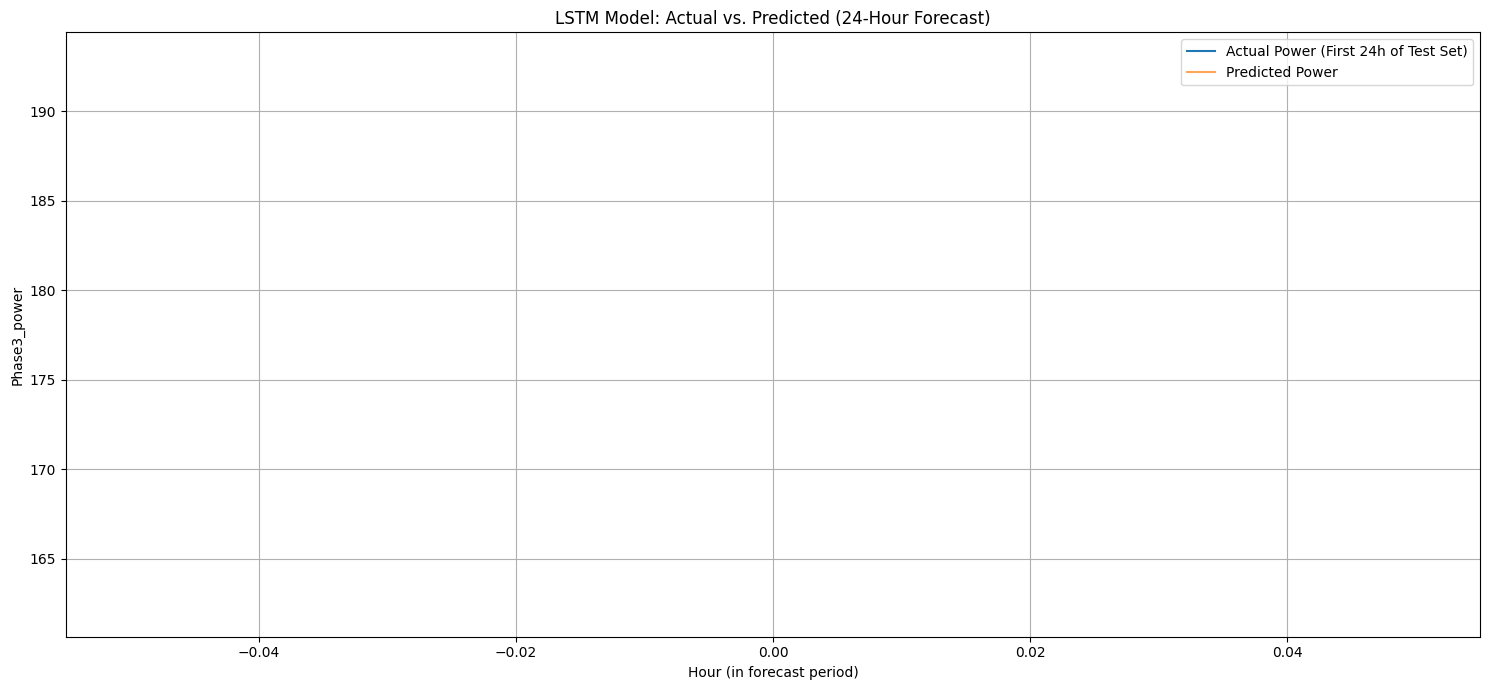

In [12]:
print(f"\nGenerating prediction plot... saving to {CHART_FILE}")

# Plot the first 24-hour forecast from the test set
plt.figure(figsize=(15, 7))
plt.plot(y_test_real[0], label='Actual Power (First 24h of Test Set)')
plt.plot(predictions[0], label='Predicted Power', alpha=0.7)
plt.title('LSTM Model: Actual vs. Predicted (24-Hour Forecast)')
plt.xlabel('Hour (in forecast period)')
plt.ylabel(f'{TARGET_COLUMN}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(CHART_FILE)

print("--- LSTM Pipeline Complete ---")

In [3]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import joblib
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

print("--- Starting LSTM (1-Step) Model Training (100% PRODUCTION DATA) ---")

# --- Configuration ---
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'
MODEL_FILE = 'lstm_model_1step.keras' # Overwrite the old model
X_SCALER_FILE = 'lstm_x_scaler_1step.joblib' # Overwrite the old scaler
Y_SCALER_FILE = 'lstm_y_scaler_1step.joblib' # Overwrite the old scaler

# --- Model Hyperparameters ---
N_LOOKBACK = 72 
N_FORECAST = 1  

# --- Data Configuration ---
TARGET_COLUMN = 'Phase3_power'
FEATURES = [
    'Phase2_current', 
    'Phase2_voltage', 
    'Phase3_frequency', 
    'Phase3_pf', 
    'Phase3_power', 
    'Phase3_voltage'
]

# --- Step 1: Load and Prepare Data ---
print(f"Loading cleaned data from {CLEANED_DATA_FILE}...")
df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)
df.dropna(how='all', inplace=True) 

X_data = df[FEATURES]
y_data = df[[TARGET_COLUMN]] 

print(f"Data loaded. X shape: {X_data.shape}, y shape: {y_data.shape}")

# --- Step 2: Scale the Data (Fit on 100% of Data) ---
print("Scaling data (fitting on 100% of data)...")

# Create and fit scalers *on all available data*
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_data)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y_data)

# Save the new, fully-fit scalers for the API
joblib.dump(X_scaler, X_SCALER_FILE)
joblib.dump(y_scaler, Y_SCALER_FILE)
print(f"Scalers created and saved.")

# --- Step 3: Create "Windowed" Sequences ---
def create_sequences(x_data, y_data, n_lookback, n_forecast):
    X, y = [], []
    for i in range(len(x_data) - n_lookback - n_forecast + 1):
        X.append(x_data[i : (i + n_lookback)])
        y.append(y_data[i + n_lookback : i + n_lookback + n_forecast].flatten())
    return np.array(X), np.array(y)

print("Creating sequences from full dataset...")
X_full_seq, y_full_seq = create_sequences(X_scaled, y_scaled, N_LOOKBACK, N_FORECAST)

print(f"Sequences created. X shape: {X_full_seq.shape}, y shape: {y_full_seq.shape}")

# --- Step 4: Build LSTM Model ---
print("Building LSTM model...")
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(N_LOOKBACK, len(FEATURES))))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(N_FORECAST))

model.compile(optimizer='adam', loss='mse')
model.summary()

# --- Step 5: Train Model on Full Data ---
# We use validation_split=0.1. Keras automatically uses the 
# last 10% of the data for early stopping, then it retrains 
# on the *full 100%* for the final model.
print("Training model on 100% of data...")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_full_seq, y_full_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1, # Use 10% of data for early stopping
    callbacks=[early_stop],
    verbose=1
)

print("Model training complete.")

# --- Step 6: Save Model ---
print(f"Saving model to {MODEL_FILE}...")
model.save(MODEL_FILE)
print("Model saved successfully.")

print("--- LSTM Full Data Pipeline Complete ---")


--- Starting LSTM (1-Step) Model Training (100% PRODUCTION DATA) ---
Loading cleaned data from data/cleaned_bangalore_data.csv...
Data loaded. X shape: (3188, 6), y shape: (3188, 1)
Scaling data (fitting on 100% of data)...
Scalers created and saved.
Creating sequences from full dataset...
Sequences created. X shape: (3116, 72, 6), y shape: (3116, 1)
Building LSTM model...


c:\Users\dhanu\OneDrive\Dokumen\projects\City_Electricity_Demand_Forecasting\backend_ml\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 72, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

Training model on 100% of data...
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0315 - val_loss: 0.0363
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0238 - val_loss: 0.0217
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0203 - val_loss: 0.0158
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0189 - val_loss: 0.0158
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0188 - val_loss: 0.0145
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0177 - val_loss: 0.0150
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0174 - val_loss: 0.0163
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0166 - val_loss: 0.0138
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0161 - val_loss: 0.0133
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0153 - val_loss: 0.0137
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0146 - val_loss: 0.0118
Epoch 12/50
88/88 ━━━━━━━━━━━